## Import Packages

In [1]:
#importing some useful packages

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob # glob API for importing list of (calibration) images
from copy import copy

## Define a class

In [2]:
# Define a class to receive the characteristics of each line detection (object-oriented programming: line is a object)
class Line():
    def __init__(self):
        # True if line was detected in the frame before
        self.detected = False # set to True when line is successfully detected
        # x values for currently detected line pixels
        self.current_fitx = None
        # y values for detected line pixels
        self.current_fity = None
        # list of the x values of the last N fits of the line
        self.previous_fitx = []
        # averaged
        self.mean_fitx = []
        # polynomial coefficients for the most recent fit
        self.current_poly = [np.array([False])]
        # best polynomial coefficients for the last iteration
        self.prev_poly = [np.array([False])]

    # function for collecting the x calues of detected lines frame by frame in order to average the previous fits
    # this function is used for smoothing over the last N frames if line detections jump around from frame to frame (jitter)
    def average_pre_lanes(self): 
        tmp = copy(self.previous_fitx)
        tmp.append(self.current_fitx)
        self.mean_fitx = np.mean(tmp, axis=0)

    def append_fitx(self):
        if len(self.previous_fitx) == N:
            self.previous_fitx.pop(0)
        self.previous_fitx.append(self.mean_fitx)

    def process(self, ploty):
        self.current_fity = ploty
        self.average_pre_lanes()
        self.append_fitx()
        self.prev_poly = self.current_poly

### Initiating lines (objects) with the class

In [3]:
# for monitoring characteristics of detected lines and sanity check them later

left_lane = Line()
right_lane = Line()

N = 5 # number of previous lines to monitor. Needed for smoothing and computing average fit over last N frames
LANEWIDTH = 3.7  # highway lane width in US: 3.7 meters

### Parameters for perspective transform

In [4]:
# source points in the original image that will be warped
src = np.float32([[  100.,   719.],  # Links unten
                  [  542.,   470.],  # Links oben
                  [  738.,   470.],  # Rechts oben
                  [ 1180.,   719.]]) # Rechts unten
'''
    
#source points for A99Munich test video
src = np.float32([[  235.,   719.], 
                  [  580.,   536.],
                  [  688.,   536.],
                  [ 1003.,   719.]])
'''                  

# destination points in the target image (after warping)  
dst = np.float32([[ 200.,  720.],
                  [ 200.,    0.],
                  [ 1080.,    0.],
                  [ 1080.,  720.]])
  
        
# use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

## Camera calibration using chessboard images

In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # nx=9 and ny=6

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg') # importing the glob API

# Step through the list and search for chessboard corners and if found, add object and image points (needed later in cv.calibrateCamera())
for fname in images:
    img = plt.imread(fname)
    # no cv2.undistort(img, mtx, dist, None) here because cal images are not distorted (only the first one a little bit maybe)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # why? to find corners easily in the next step
                                                # if you are using cv2.imread() or the glob API, as happens here,
                                                # this will read in a BGR image and you should convert to grayscale
                                                # using cv2.COLOR_BGR2GRAY.

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None) # nx=9 and ny=6 (ret=return)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp) # für jedes Bild in der for-Schleife wird dasselbe array (objp) hinzugefügt
        imgpoints.append(corners)

        # Draw and display the corners (this is not necessary but helpful for demonstration purposes)
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # plt.imshow(img)

# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)

## Helper functions (for both pipelines)

In [6]:
# function that takes an image, object points, and image points, performs the camera calibration, image distortion correction
# and returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    undist = cv2.undistort(img, mtx, dist, None, mtx)  # undist war im Kurs dst (destination)
    return undist

def warp(img, M):

    # Compute and apply perspective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

# thresholding means as much as creating a binary by means of thresholds
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100), thresh=(20, 100)):
    
    # Grayscale image? No! Why? Single color needed to calculate derivatives >> "single color" can also mean h-/l- or s-channel! 
    # We already saw that standard grayscaling lost color information for the lane lines. This is why we do not grayscale.
    # Exploring gradients in other colors spaces / color channels shows that l-channel works better
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # threshold gradient
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize) # Sobel x (identifies vertical edges)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize)
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    gradient_thresholded = np.zeros_like(dir_binary)
    gradient_thresholded[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(gradient_thresholded), gradient_thresholded, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradient_thresholded)
    combined_binary[(s_binary == 1) | (gradient_thresholded == 1)] = 1
    
    return combined_binary


## start: functions for gradient threshold

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    
    # 1) Convert to grayscale
    
    # Grayscale image? No! Why? Single color needed to calculate derivatives >> "single color" can also mean h-/l- or s-channel! 
    # We already saw that standard grayscaling lost color information for the lane lines. This is why we do not grayscale.
    # Exploring gradients in other colors spaces / color channels shows that other channels might work better
    
    # instead taking hsv color space
    #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #h_channel = hsv[:,:,0]
    #s_channel = hsv[:,:,1]
    #v_channel = hsv[:,:,2]
    
    # instead taking hls color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # 2) Calculate the derivative in x or y given orient = 'x' or 'y' and
    # 3) take the absolute
    if orient == "x":
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobel = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    else:
        sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobely) # absolute value image
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Threshold: Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1   
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

## end: functions for gradient threshold


def find_lane_pixels(binary_warped):
    
    '''
    Findet mit der sliding windows Methode die Pixel im binary_warped, die zu den Spurlinien gehören und gibt sie wie folgt aus:
    
    leftx >> [308 309 310 ...362 363 364] Liste der x-Koordinaten von Pixeln, die zur left lane gehören müssten
    lefty >> [640 640 640 ... 159 159 159] List der y-Koordinaten von Pixeln, die zur right lane gehören müssten
    rightx >> []
    righty >> []
    
    Außerdem werden auf das Input-Bild die sliding windows (grüner Rahmen) gezeichnet.
    
    '''
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    '''
    Die Polynomfunktion wird ermittelt (np.polyfit()) und die sich daraus ergebende Linie gelb eingezeichnet in das Input-image.
    Außerdem werden die zu Beginn der function ermittelten lane pixels rot (left lane) bzw. blau (right lane) eingefärbt.
    (Das Zeichnen der windows (grüner Rahmen) geschieht in der function find_lane_lines, die die sliding windows Methode nutzt.)
    
    
    Mit Hilfe der Pixel, die zu den lane lines gehören (diese werden durch Aufruf der Funktion find_lane_lines()
    separat ermittelt; Ergebnis z.B. leftx >> Liste mit den x-Koordinaten der left lane),
    wird eine passende Polynomfunktion x = A*y**2 + B*y + C ermittelt ("gefittet"). Dabei sind:
        
        left_fit >> [A B C] Polynomkoeffizienten
        right_fit >> dito
        
        ploty >> z.B. [0 1 2 3 4 ... 717 718 719] y-Koordinaten des Polynoms bzw. der sich daraus ergebenden Linie
        
        left_fitx >> z.B. [375 374,8 374,65 374,48 ... 319] x-Koordinaten des Polynoms bzw. der sich daraus ergebenden Kurve
                  >> errechnet sich aus A*y**2 + B*y + C mit y = ploty
        right_fitx >> dito
        
    '''
    
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2) # left_fit beinhaltet die Koeffizienten A, B und C
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]) # ploty ist eine Liste von [0 1 2 .... 719]
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] # left_fitx ist die gesamte Funktion (x = A*y**2 + B*y + C) des gefundenen, passenden Polynoms "fit"
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0] # Pixel der left line werden rot dargestellt, Pixel der right line blau
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow') # x-Koordinaten des Polynoms (left_fitx) und y-Koordinaten des Polynoms (ploty) zum Plotten
    plt.plot(right_fitx, ploty, color='yellow')

    #return out_img, left_fit, right_fit, ploty
    return left_fit, right_fit

def search_around_poly(left_fit, right_fit, binary_warped):
    
    # width of the margin around the previous polynomial to search
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
 
    # fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def measure_curvature_real(ploty, leftx, rightx):
    
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Convert polynomials to real world
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (left_curverad+right_curverad)/2.0

def off_center(left, mid, right):
    """
    :param left: left line position
    :param mid:  car position
    :param right: right line position
    :return: True or False, indicator of off center driving
    """
    a = mid - left
    b = right - mid
    width = right - left

    if a >= b:  # driving right off
        offset = a / width * LANEWIDTH - LANEWIDTH /2.0
    else:       # driving left off
        offset = LANEWIDTH /2.0 - b / width * LANEWIDTH

    return offset


def compute_car_offcenter(ploty, left_fitx, right_fitx, undist):

    # Create an image to draw the lines on
    height = undist.shape[0]
    width = undist.shape[1]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    bottom_l = left_fitx[height-1]
    bottom_r = right_fitx[0]

    offcenter = off_center(bottom_l, width/2.0, bottom_r)

    return offcenter, pts

def create_output(binary_warped, Minv, undist, curvature, offcenter, pts):
    ## Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # Minv = perspective_Minv
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    lane_colored = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # img = cv.putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])
    info_cur = "Radius of Curvature {:6.1f} m".format(curvature)
    info_pos = "Vehicle is {:6.1f} m off center".format(offcenter)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(lane_colored, info_cur, (800,100), font, 0.8, (255,255,255), 1,cv2.LINE_AA)
    cv2.putText(lane_colored, info_pos, (800,150), font, 0.8, (255,255,255), 1,cv2.LINE_AA)
    
    return lane_colored

# tracker is the function for fitting polynomials that is started when there was already successfully found a polynomial/line
# in a previous frame. A search around the existing polynomial/line is done which is more efficient (kind of targeted search)
def tracker(binary_warped, ploty):

    #left_fit, right_fit = window_search(left_lane.prev_poly, right_lane.prev_poly, binary_warped, margin=50)
    left_fit, right_fit = search_around_poly(left_lane.prev_poly, right_lane.prev_poly, binary_warped)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    std_value = np.std(right_fitx - left_fitx) # np.std computes the standard deviation along the specified axis
    if std_value < 21.25:             # test if the left and right line (both detected) are parallel
        left_lane.detected = True
        right_lane.detected = True
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.current_fitx = left_fitx
        right_lane.current_fitx = right_fitx
    else:
        left_lane.detected = False
        right_lane.detected = False
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        left_lane.current_fitx = left_lane.previous_fitx[-1]
        right_lane.current_fitx = right_lane.previous_fitx[-1]


def detector(binary_warped, ploty):

    #left_fit, right_fit = full_search(binary_warped)
    left_fit, right_fit = fit_polynomial(binary_warped)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    std_value = np.std(right_fitx - left_fitx)
    if std_value < 21.25:             # test if the left and right line (both detected) are parallel
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.current_fitx = left_fitx
        right_lane.current_fitx = right_fitx
        left_lane.detected = True
        right_lane.detected = True
    else:
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        if len(left_lane.previous_fitx) > 0:
            left_lane.current_fitx = left_lane.previous_fitx[-1]
            right_lane.current_fitx = right_lane.previous_fitx[-1]
        else:
            left_lane.current_fitx = left_fitx
            right_lane.current_fitx = right_fitx
        left_lane.detected = False
        right_lane.detected = False

## Pipeline (test images)

### Read in an image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


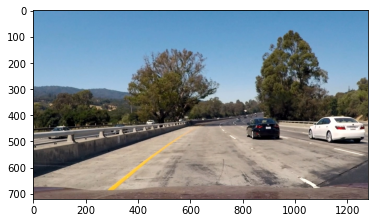

In [7]:
#reading in an image
#img = mpimg.imread('test_images/signs_vehicles_xygrad.png')
#img = mpimg.imread('test_images/straight_lines1.jpg')
#img = mpimg.imread('test_images/straight_lines2.jpg')
img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
#img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('test_images/test5.jpg')
#img = mpimg.imread('test_images/test6.jpg')
#img = mpimg.imread('test_images/test_A99Munich_1.jpg')

# ATTENTION: If you are using cv2.imread() or the glob API, this will read in a BGR image and you should convert to grayscale
# using cv2.COLOR_BGR2GRAY.

#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)  # single color channel image, e.g. gray , call as plt.imshow(gray, cmap='gray')

### Distortion correction

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


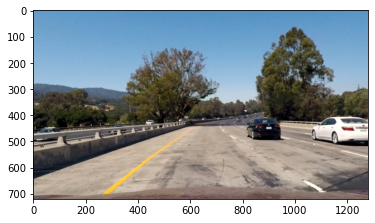

In [8]:
undist = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undist)
print('This image is:', type(undist), 'with dimensions:', undist.shape)

### Color & Gradient Threshold

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280)


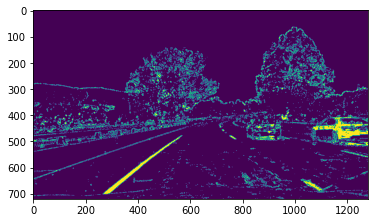

In [9]:
img_binary = threshold(undist)
plt.imshow(img_binary)
print('This image is:', type(img_binary), 'with dimensions:', img_binary.shape)

### Perspective Transform to "birds-eye view"

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280)


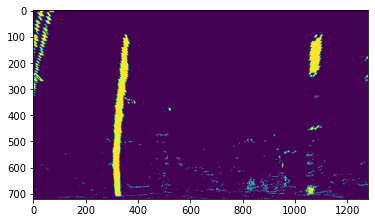

In [10]:
binary_warped = warp(img_binary, M)
plt.imshow(binary_warped)
print('This image is:', type(binary_warped), 'with dimensions:', binary_warped.shape)

### Start detector or tracker to find lines (this includes to fit polynomials)

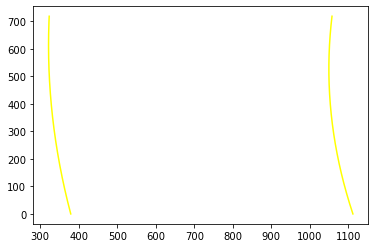

In [11]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
visualization = False
# print(left_lane.detected) # DEBUG

if left_lane.detected:  # start tracker (am Anfang ist self.detected FALSE >> starts always first with detector
    tracker(binary_warped, ploty) # later: Kann nicht das "top-down" verwendet werden und die Schritte "Grayscale"
                                                     # und "Crop the binary image" übersprungen werden?
else:                   # start detector
    detector(binary_warped, ploty)

### Determine the curvature of the lane

In [12]:
# average over the previous N frames to get the averaged lanes
left_lane.process(ploty) # process() is a class function
right_lane.process(ploty)

# measure the lane curvature
curvature = measure_curvature_real(ploty, left_lane.mean_fitx, right_lane.mean_fitx)

### Determine vehicle position with respect to the center

In [13]:
# vehicle's off-center in meters
offcenter, pts = compute_car_offcenter(ploty, left_lane.mean_fitx, right_lane.mean_fitx, undist)

### Drawing

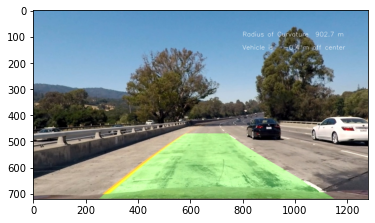

In [14]:
lane_colored = create_output(binary_warped, Minv, undist, curvature, offcenter, pts)
plt.imshow(lane_colored)

## Pipeline (video)

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(img):
    '''
    total pipeline from above as a function
    '''
    
    # distortion correction
    undist = cal_undistort(img, objpoints, imgpoints)
    
    # color & gradient thresholding
    img_binary = threshold(undist)
    
    # perspective transform to "birds-eye view"
    binary_warped = warp(img_binary, M)
    
    # start detector or tracker to find the lanes
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if left_lane.detected:  # start tracker if detection was successfull previously. Then you can do proximity search
                            # (search_around_poly()) which is more efficient than a full search ("fit_polynomial()")
        tracker(binary_warped, ploty)
    else:  # start detector. This will always be the case for the very first frame of a video because an initialized lane, 
            # e.g. "left_lane = Line()" by means of the __init__ function of the class, starts with self.detected = False per 
            # default
        detector(binary_warped, ploty)

    # average among the previous N frames to get the averaged lanes
    left_lane.process(ploty)
    right_lane.process(ploty)

    # measure the lane curvature
    curvature = measure_curvature_real(ploty, left_lane.mean_fitx, right_lane.mean_fitx)
    
    # compute the car's off-center in meters
    offcenter, pts = compute_car_offcenter(ploty, left_lane.mean_fitx, right_lane.mean_fitx, undist)
   
    # Drawing: combine all images into final video output (only for visualization purpose)
    lane_colored = create_output(binary_warped, Minv, undist, curvature, offcenter, pts)
        
    return lane_colored

### Testing on project video:

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 8min 46s


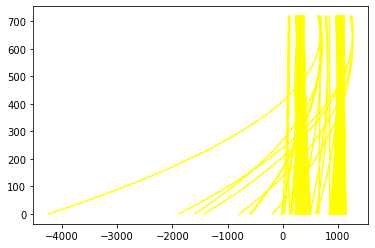

In [17]:
output = 'project_video_output.mp4'
## To speed up the testing process, one can use pipeline on a shorter subclip of the video with .subclip(start_second,end_second)
clip1 = VideoFileClip("test_videos/project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images
%time clip.write_videofile(output, audio=False)

Play the video inline:

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Testing on german highway A99 in Munich

I wanted to know if this algorithm also runs on videos taken by myself. So, what did I do? I took my wife out on a ... nope, I did not take her out on a date but I took her out on the next motorway from our apartment (isn't that even a better date?). She had to drive the car and I recorded a video of the ride on the highway. Then I tested the algorithm on this video.

Note: Before running the pipeline, I had to identify new source points because my video was recorded under different conditions (angles, perspective, etc.). This is why you can find two different source points in my code. Of course, camera calibration needs to be done from scratch.

Here is the result:

In [19]:
output_munich = 'A99Munich_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_munich))